In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
import gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

In [2]:
class DeepSARSA:
    def __init__(self, num_states, num_actions):
        self.num_states = num_states
        self.num_actions = num_actions
        self.alpha = 0.001
        self.gamma = 0.99
        self.epsilon = 1.
        self.epsilon_decay = .99999
        self.epsilon_min = 0.2
        self.model = nn.Sequential(
            nn.Linear(self.num_states, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, self.num_actions)
        )
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)
        
    def update(self, state, action, reward, next_state, next_action, done):
        self.decrease_epsilon()
        self.optimizer.zero_grad()
        
        q_value = self.model(state)[action]
        next_q_value = self.model(next_state)[next_action].detach()
        
        q_target = reward + (1 - int(done)) * self.gamma * next_q_value
        q_error = (q_target - q_value) ** 2
        
        q_error.backward()
        self.optimizer.step()
        
        return q_error.item()
    
    def decrease_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def act(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            q_values = self.model(state)
            action = torch.argmax(q_values).item()
            
        return action

In [3]:
from utils import gen_wrapped_env, show_video

In [4]:
env = gen_wrapped_env('MiniGrid-Empty-6x6-v0')
obs = env.reset()

agent = DeepSARSA(obs.shape[0], 3)

In [5]:
rewards = []
for ep in range(5000):
    done = False
    obs = torch.FloatTensor(env.reset())
    action = agent.act(obs)

    ep_rewards = 0
    losses = []
    while not done:
        next_obs, reward, done, info = env.step(action)
        next_obs = torch.FloatTensor(next_obs)

        next_action = agent.act(next_obs)

        loss = agent.update(obs, action, reward, next_obs, next_action, done)
        losses.append(loss)
        
        ep_rewards += reward
        obs = next_obs
        action = next_action
    rewards.append(ep_rewards)
    ep_loss = sum(losses) / len(losses)
    if (ep+1) % 10 == 0:
        print("episode: {}, eps: {:.3f}, loss: {:.3f}, rewards: {}".format(ep+1, agent.epsilon, ep_loss, ep_rewards))
env.close()


episode: 10, eps: 0.995, loss: 0.023, rewards: 0.6399999999999999
episode: 20, eps: 0.991, loss: 0.002, rewards: 0
episode: 30, eps: 0.986, loss: 0.000, rewards: 0
episode: 40, eps: 0.982, loss: 0.001, rewards: 0
episode: 50, eps: 0.977, loss: 0.011, rewards: 0.586
episode: 60, eps: 0.973, loss: 0.001, rewards: 0
episode: 70, eps: 0.968, loss: 0.000, rewards: 0
episode: 80, eps: 0.964, loss: 0.001, rewards: 0
episode: 90, eps: 0.960, loss: 0.000, rewards: 0
episode: 100, eps: 0.956, loss: 0.001, rewards: 0
episode: 110, eps: 0.952, loss: 0.001, rewards: 0.352
episode: 120, eps: 0.947, loss: 0.001, rewards: 0
episode: 130, eps: 0.943, loss: 0.000, rewards: 0
episode: 140, eps: 0.938, loss: 0.000, rewards: 0
episode: 150, eps: 0.933, loss: 0.000, rewards: 0
episode: 160, eps: 0.929, loss: 0.001, rewards: 0
episode: 170, eps: 0.926, loss: 0.001, rewards: 0
episode: 180, eps: 0.921, loss: 0.000, rewards: 0
episode: 190, eps: 0.917, loss: 0.002, rewards: 0.42399999999999993
episode: 200, ep

In [6]:
show_video()

In [7]:
pd.Series(rewards).to_csv('./logs/rewards_deepsarsa_gridworld.csv')

In [9]:
sarsa_logs = pd.read_csv('./logs/rewards_sarsa.csv', index_col=False).iloc[:, 1]
q_logs = pd.read_csv('./logs/rewards_qlearning.csv', index_col=False).iloc[:, 1]
exp_sarsa_logs = pd.read_csv('./logs/rewards_expectedsarsa.csv', index_col=False).iloc[:, 1]
deepsarsa_logs = pd.read_csv('./logs/rewards_deepsarsa_gridworld.csv', index_col=False).iloc[:, 1]

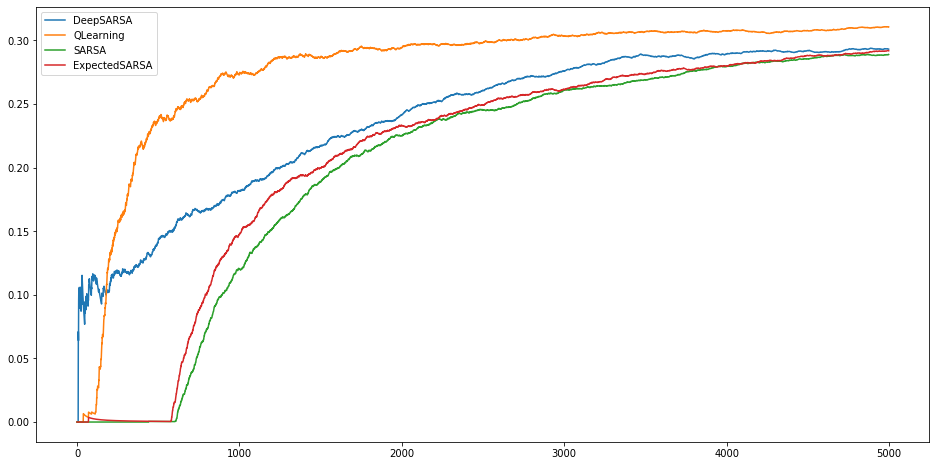

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(deepsarsa_logs.cumsum() / (pd.Series(np.arange(exp_sarsa_logs.shape[0]))+1), label="DeepSARSA")
plt.plot(q_logs.cumsum() / (pd.Series(np.arange(q_logs.shape[0]))+1), label="QLearning")
plt.plot(sarsa_logs.cumsum() / (pd.Series(np.arange(sarsa_logs.shape[0]))+1), label="SARSA")
plt.plot(exp_sarsa_logs.cumsum() / (pd.Series(np.arange(exp_sarsa_logs.shape[0]))+1), label="ExpectedSARSA")
plt.legend()